In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("examples/")

# Загрузка и предобработка данных

In [3]:
prices = pd.read_excel("factors/russia/monthlyprice.xlsx", index_col=0, parse_dates=True)
pe = pd.read_excel("factors/russia/PE.xlsx", index_col=0, parse_dates=True)
avg_volume = pd.read_excel("factors/russia/betafilter.xlsx", index_col=0, parse_dates=True)
index = pd.read_excel("factors/russia/imoex.xlsx", index_col=0, parse_dates=True)

prices, pe, avg_volume, index = pqr.utils.replace_with_nan(prices, pe, avg_volume, index)

# Строим фактор стоимости и бенчмарк

In [4]:
universe = pqr.Universe(prices)
universe.filter(avg_volume >= 10_000_000)

preprocessor = [
    pqr.Filter(universe.mask),
    pqr.LookBackMean(3),
    pqr.Hold(3),
]

value = pqr.Factor(pe, "less", preprocessor)

benchmark = pqr.Benchmark.from_index(index["IMOEX"], name="IMOEX")

# Конструируем портфель из 50% лучших по фактору стоимости компаний

In [5]:
q05 = pqr.fm.Quantiles(0, 0.5)

portfolio = pqr.Portfolio(
    universe,
    longs=q05(value),
    allocation_strategy=pqr.EqualWeights(),
    name="Top 50%"
)

Смотрим его доходность и базовые статистики.

,Top 50%
"Mean Return, %",1.48*** (2.76)
"Volatility, %",7.65
Sharpe Ratio,0.67
"Mean Excess Return, %",2.25
"Alpha, %",2.52 (0.98)
Beta,0.98


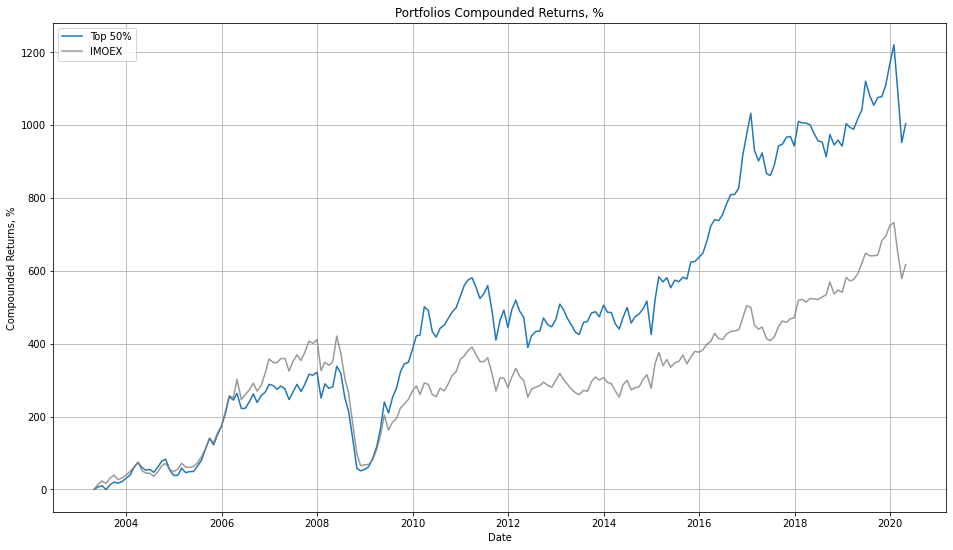

In [6]:
summary = pqr.dash.Dashboard(
    pqr.dash.Table(
        pqr.metrics.MeanReturn(annualizer=1, statistics=True),
        pqr.metrics.Volatility(annualizer=1),
        pqr.metrics.SharpeRatio(rf=0),
        pqr.metrics.MeanExcessReturn(benchmark),
        pqr.metrics.Alpha(benchmark, statistics=True),
        pqr.metrics.Beta(benchmark),
    ),
    pqr.dash.Graph(pqr.metrics.CompoundedReturns(), benchmark=benchmark, figsize=(16, 9)),
)
summary([portfolio])

# Пробуем поскейлить

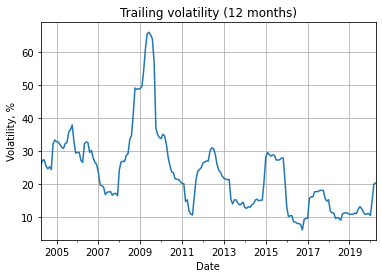

In [7]:
(pqr.metrics.TrailingVolatility()(portfolio) * 100).plot()

plt.title("Trailing volatility (12 months)")
plt.xlabel("Date")
plt.ylabel("Volatility, %")
plt.grid();

Волатильность портфеля выглядит неплохо, но видно, что в периоды высокой волатильности (особенно 2008 г.) портфель проигрывает бенчмарку. Попробуем это исправить за счет скейлинга по волатильности.

In [8]:
class VolatilityScaling:
    def __init__(self, universe: pqr.Universe, target: float = 0.1):
        self.universe = universe
        self.target = target
        
    def __call__(self, positions: pd.DataFrame) -> pd.DataFrame:
        # считаем доходность портфеля
        portfolio_returns = self.universe(positions)
        # считаем волатильность доходности портфеля
        volatility = portfolio_returns.rolling(12).std(ddof=1).iloc[12:] * np.sqrt(12)
        # строим матрицу фактора (дублируем колонки)
        w, vol = pqr.utils.align(positions, volatility)
        volatility_factor_values = np.ones_like(w) * vol.to_numpy()[:, np.newaxis]
        volatility_factor = pd.DataFrame(
            volatility_factor_values,
            index=w.index,
            columns=w.columns
        )
        
        
        scaler = pqr.ScalingByFactor(
            factor=pqr.Factor(volatility_factor, better="less"),
            target=self.target
        )
        
        return scaler(positions)       

In [9]:
portfolio_scaled = pqr.Portfolio(
    universe,
    longs=q05(value),
    allocation_strategy=[pqr.EqualWeights(), VolatilityScaling(universe, 0.15)],
    name="Top 50% scale"
)

Посмотрим на получившееся плечо портфеля.

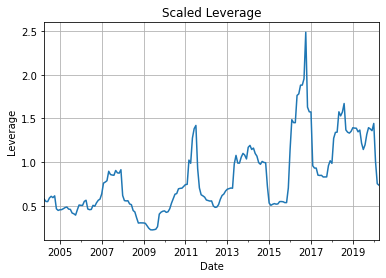

In [10]:
portfolio_scaled.positions.sum(axis=1).plot()

plt.title("Scaled Leverage")
plt.xlabel("Date")
plt.ylabel("Leverage")
plt.grid();

,Top 50% scale
"Mean Return, %",0.77** (2.04)
"Volatility, %",5.26
Sharpe Ratio,0.51
"Mean Excess Return, %",-2.60
"Alpha, %",2.39 (0.83)
Beta,0.58


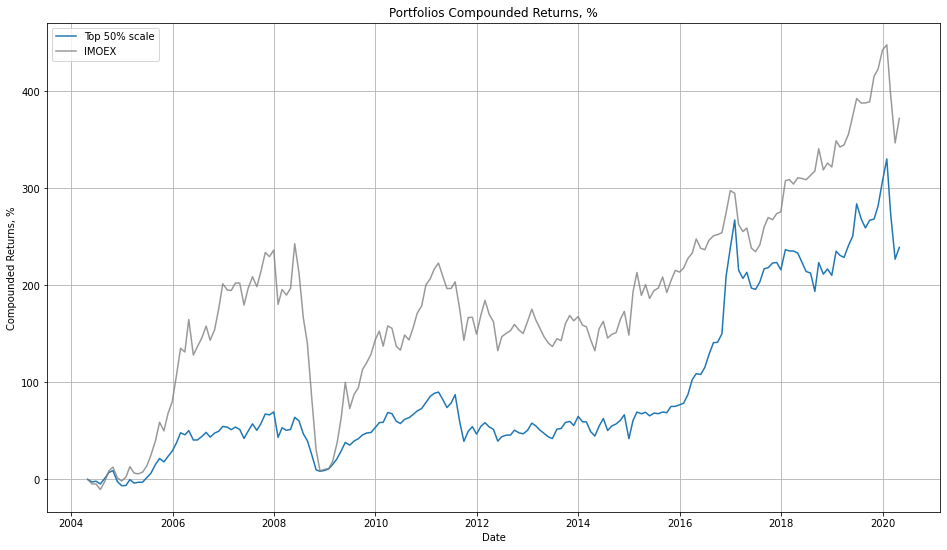

In [11]:
summary([portfolio_scaled])

Стало хуже, потому что в 2008 году пришлось понижать плечо слишком поздно, за счет чего не был пойман отскок рынка (зато падение поймали отлично), а в 2017 году на экстремально низкой волатильности портфеля было повышено плечо очень сильно, что привело к большим потерям. Попробуем ограничить плечо.

In [12]:
portfolio_scaled_limits = pqr.Portfolio(
    universe,
    longs=q05(value),
    allocation_strategy=[pqr.EqualWeights(), VolatilityScaling(universe, 0.15), pqr.LeverageLimits(0.8, 1.5)],
    name="Top 50% scaled with limits"
)

Видно, что теперь не позволяем портфелю быть заполненным менее чем на 80%, но плечо ограничиваем в 1.5

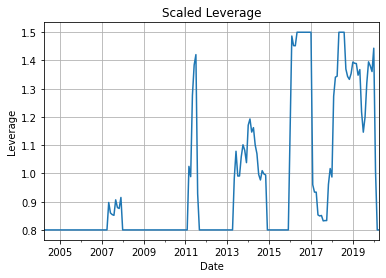

In [13]:
portfolio_scaled_limits.positions.sum(axis=1).plot()

plt.title("Scaled Leverage")
plt.xlabel("Date")
plt.ylabel("Leverage")
plt.grid();

Но сильно лучше не стало: хотя в 2017 ушла такая бешеная волатильность портфеля, после 2008 оставание никуда не делось.

,Top 50%,Top 50% scale,Top 50% scaled with limits
"Mean Return, %",1.48*** (2.76),0.77** (2.04),1.14*** (2.35)
"Volatility, %",7.65,5.26,6.72
Sharpe Ratio,0.67,0.51,0.59
"Mean Excess Return, %",2.29,-3.40,0.99
"Alpha, %",2.20 (0.88),1.79 (0.63),2.59 (1.06)
Beta,1.01,0.59,0.87


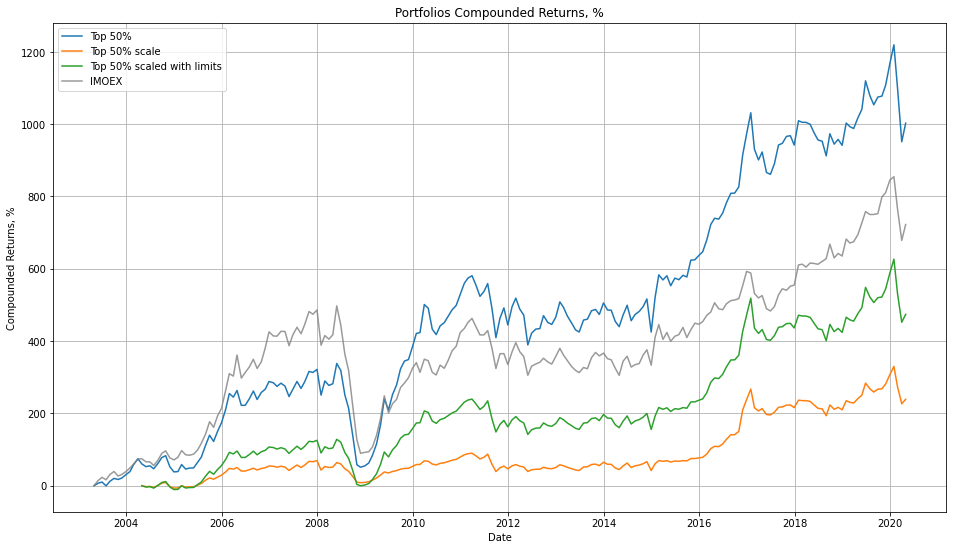

In [14]:
summary([portfolio, portfolio_scaled, portfolio_scaled_limits])